#https://github.com/pnetsiri/JEBI/blob/main/TV_CustomerReviews.json


In [27]:
import pandas as pd
import numpy as np

import json
import requests

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases

#spacy
import spacy
# from stop_words import get_stop_words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

#vis
import pyLDAvis
import pyLDAvis.gensim_models

In [4]:
# Fetch the JSON data
url = "https://raw.githubusercontent.com/pnetsiri/JEBI/main/TV_CustomerReviews.json"
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Load JSON data using utf-8-sig encoding
    data = json.loads(response.content.decode('utf-8-sig'))

    # Create DataFrame from JSON data
    df = pd.DataFrame(data)
    print(df.head())  # Display the first few rows of the DataFrame
else:
    print("Failed to fetch data. Status code:", response.status_code)

                                              Review
0  TV arrived quickly and was easy to set up. Gre...
1  Great t.v. Absolutely awesome! The remote will...
2  No recomiendo este televisorAl inicio el telev...
3  If this wouldn’t be such a hassle I would retu...
4                        After 5 months, not working


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1937 entries, 0 to 1936
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1937 non-null   object
dtypes: object(1)
memory usage: 15.3+ KB


In [6]:
df.isnull().sum()

Review    0
dtype: int64

In [7]:
# create a generator function to create tokens from each doc(each review) in the dataframe
df['tokenized_review'] = df['Review'].apply(lambda x: simple_preprocess(str(x),deacc=True))


In [8]:
stop_words = stopwords.words('english') + list(string.punctuation)+['tv']

In [9]:
def rem_stop_words(tokens):
    filtered_tokens = [word.lower() for word in tokens if word.lower() not in stop_words]
    return filtered_tokens

In [10]:
df['tokenized_review']=df['tokenized_review'].apply(lambda x: rem_stop_words(x))
df.head()

,Review,tokenized_review
0,TV arrived quickly and was easy to set up. Gre...,"[arrived, quickly, easy, set, great, price, well]"
1,Great t.v. Absolutely awesome! The remote will...,"[great, absolutely, awesome, remote, trash, so..."
2,No recomiendo este televisorAl inicio el telev...,"[recomiendo, este, televisoral, inicio, el, te..."
3,If this wouldn’t be such a hassle I would retu...,"[hassle, would, return, slow, switching, thing..."
4,"After 5 months, not working","[months, working]"


In [11]:
# create function for above to apply on tokenized_reviews
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(sent,allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    tokens_out=[]
    doc = nlp(" ".join(sent))
    tokens_out=[token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return tokens_out

In [12]:
df['tokenized_review'] = df['tokenized_review'].apply(lambda x: lemmatization(x))
df['tokenized_review'].head()

0     [arrive, quickly, easy, set, great, price, well]
1    [great, absolutely, awesome, remote, trash, so...
2    [recomiendo, imagen, ideal, pelicula, embargo,...
3    [return, slow, switch, thing, remote, suck, to...
4                                        [month, work]
Name: tokenized_review, dtype: object

In [112]:
# Topic Modelling using LDA

In [13]:
# Create Corpus of preprocessed tokens - list of token lists
data_words=df['tokenized_review'].tolist()
print(data_words[2:5])

[['recomiendo', 'imagen', 'ideal', 'pelicula', 'embargo', 'despue', 'mitad', 'viene', 'este', 'tamano', 'parecer', 'es', 'puede', 'ser', 'modo', 'este'], ['return', 'slow', 'switch', 'thing', 'remote', 'suck', 'touchy', 'slight', 'bump', 'change', 'watch', 'turn', 'good', 'thing', 'nice', 'big', 'screen', 'size'], ['month', 'work']]


In [14]:
# create dictionary and corpus
id2word=corpora.Dictionary(data_words)
corpus=[id2word.doc2bow(text) for text in data_words]
print(corpus[2:4])


[[(44, 1), (45, 1), (46, 1), (47, 2), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1)], [(29, 1), (39, 1), (42, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 2), (72, 1)]]


In [15]:
print(list(id2word.token2id.items())[20:30])

[('directly', 20), ('find', 21), ('fire', 22), ('get', 23), ('girl', 24), ('golden', 25), ('history', 26), ('kick', 27), ('min', 28), ('remote', 29)]


In [16]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=1,
                                           per_word_topics=True)

In [17]:
import pprint
pprint.pprint(lda_model.print_topics())

[(0,
  '0.042*"also" + 0.042*"look" + 0.034*"clear" + 0.029*"inch" + '
  '0.024*"television" + 0.022*"make" + 0.021*"cable" + 0.020*"small" + '
  '0.016*"add" + 0.015*"video"'),
 (1,
  '0.141*"buy" + 0.084*"love" + 0.062*"price" + 0.055*"nice" + 0.041*"far" + '
  '0.036*"product" + 0.035*"money" + 0.033*"beautiful" + 0.030*"worth" + '
  '0.029*"seem"'),
 (2,
  '0.072*"set" + 0.052*"old" + 0.029*"watch" + 0.026*"happy" + 0.025*"year" + '
  '0.024*"purchase" + 0.020*"come" + 0.019*"little" + 0.018*"sure" + '
  '0.017*"way"'),
 (3,
  '0.053*"screen" + 0.032*"return" + 0.023*"come" + 0.022*"day" + '
  '0.021*"delivery" + 0.020*"order" + 0.019*"amazon" + 0.018*"damage" + '
  '0.017*"purchase" + 0.016*"box"'),
 (4,
  '0.132*"remote" + 0.092*"use" + 0.064*"easy" + 0.045*"smart" + '
  '0.044*"feature" + 0.034*"control" + 0.031*"app" + 0.023*"setup" + '
  '0.021*"button" + 0.020*"set"'),
 (5,
  '0.077*"well" + 0.029*"really" + 0.029*"movie" + 0.027*"app" + '
  '0.024*"connect" + 0.022*"work" + 

In [18]:
# coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3852362540954698


In [19]:
# compute coherence value at various values of alpha and num_topics
def compute_coherence_values(dictionary, corpus, texts, num_topics_range, alpha_range):
    
    coherence_values = []
    model_list = []
    for alpha in alpha_range:
        for num_topics in num_topics_range:
            lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=dictionary,
                                               num_topics=num_topics, 
                                               alpha=alpha,
                                               per_word_topics=True)
            model_list.append(lda_model)
            coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append((alpha, num_topics, coherencemodel.get_coherence()))
        

    return model_list, coherence_values

In [20]:
# build models across a range of num_topics and alpha
num_topics_range = [2, 6, 10, 15, 20]
alpha_range = [0.01, 0.1, 1]
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_words, 
                                                        num_topics_range=num_topics_range, 
                                                        alpha_range=alpha_range)

In [21]:
coherence_df = pd.DataFrame(coherence_values, columns=['alpha', 'num_topics', 'coherence_value'])
coherence_df.sort_values('coherence_value')


,alpha,num_topics,coherence_value
8,0.10,15,0.453493
4,0.01,20,0.458845
2,0.01,10,0.467282
10,1.00,2,0.471069
3,0.01,15,0.472642
9,0.10,20,0.477513
14,1.00,20,0.478570
5,0.10,2,0.478775
1,0.01,6,0.479122
11,1.00,6,0.479898


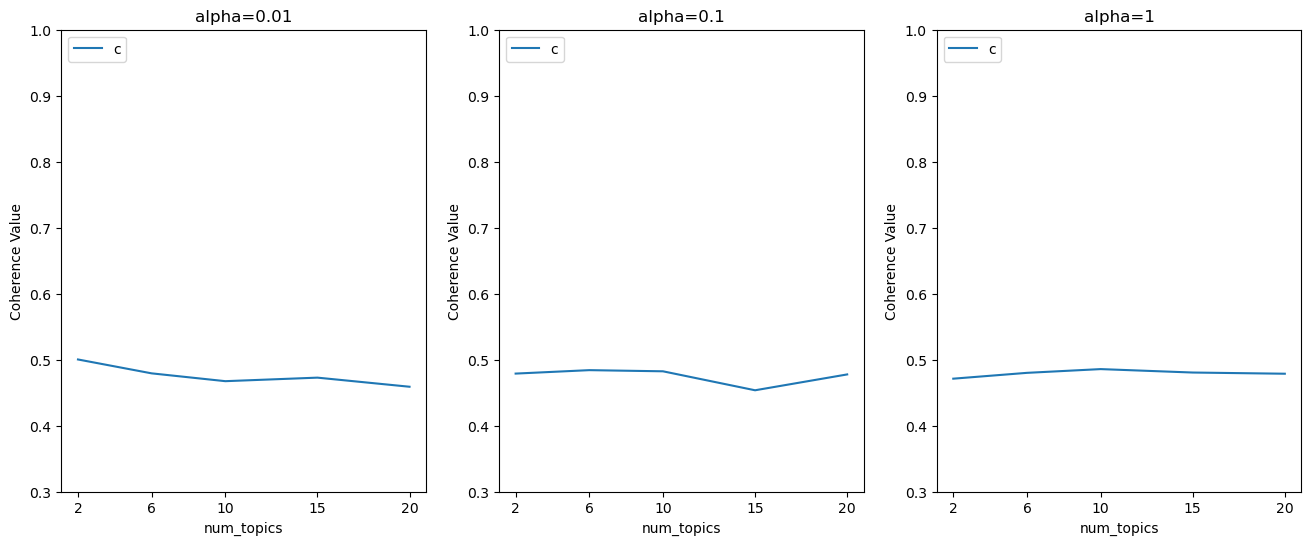

In [22]:
# plot
import matplotlib.pyplot as plt
def plot_coherence(coherence_df, alpha_range, num_topics_range):
    plt.figure(figsize=(16,6))

    for i, val in enumerate(alpha_range):

        # subplot 1/3/i
        plt.subplot(1, 3, i+1)
        alpha_subset = coherence_df[coherence_df['alpha']==val]

        plt.plot(alpha_subset["num_topics"], alpha_subset["coherence_value"])
        plt.xlabel('num_topics')
        plt.ylabel('Coherence Value')
        plt.title("alpha={0}".format(val))
        plt.ylim([0.30, 1])
        plt.legend('coherence value', loc='upper left')
        plt.xticks(num_topics_range)
plot_coherence(coherence_df, alpha_range, num_topics_range)

In [23]:
final_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=0.1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=.01,
                                           per_word_topics=True)

In [24]:
import pprint
pprint.pprint(final_lda_model.print_topics())

[(0,
  '0.020*"picture" + 0.017*"great" + 0.014*"get" + 0.014*"remote" + '
  '0.012*"good" + 0.011*"quality" + 0.010*"use" + 0.010*"buy" + 0.009*"screen" '
  '+ 0.008*"app"'),
 (1,
  '0.019*"picture" + 0.017*"sound" + 0.015*"remote" + 0.013*"use" + '
  '0.012*"quality" + 0.012*"get" + 0.010*"buy" + 0.010*"work" + 0.009*"time" + '
  '0.009*"well"')]


In [53]:
## Finding Final Coherence Score

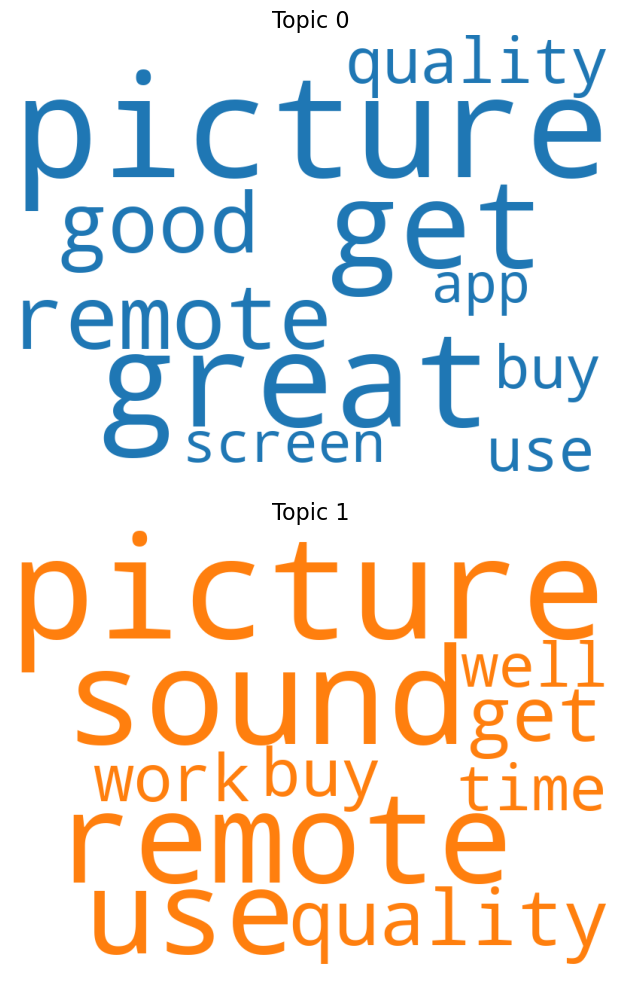

In [25]:

# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=800,
                  height=600,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = final_lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 1, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


C:\Users\agaan\AppData\Local\Temp\ipykernel_17048\3150568707.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\agaan\AppData\Local\Temp\ipykernel_17048\3150568707.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


Text(0.5, 1.05, 'Word Count and Importance of Topic Keywords')

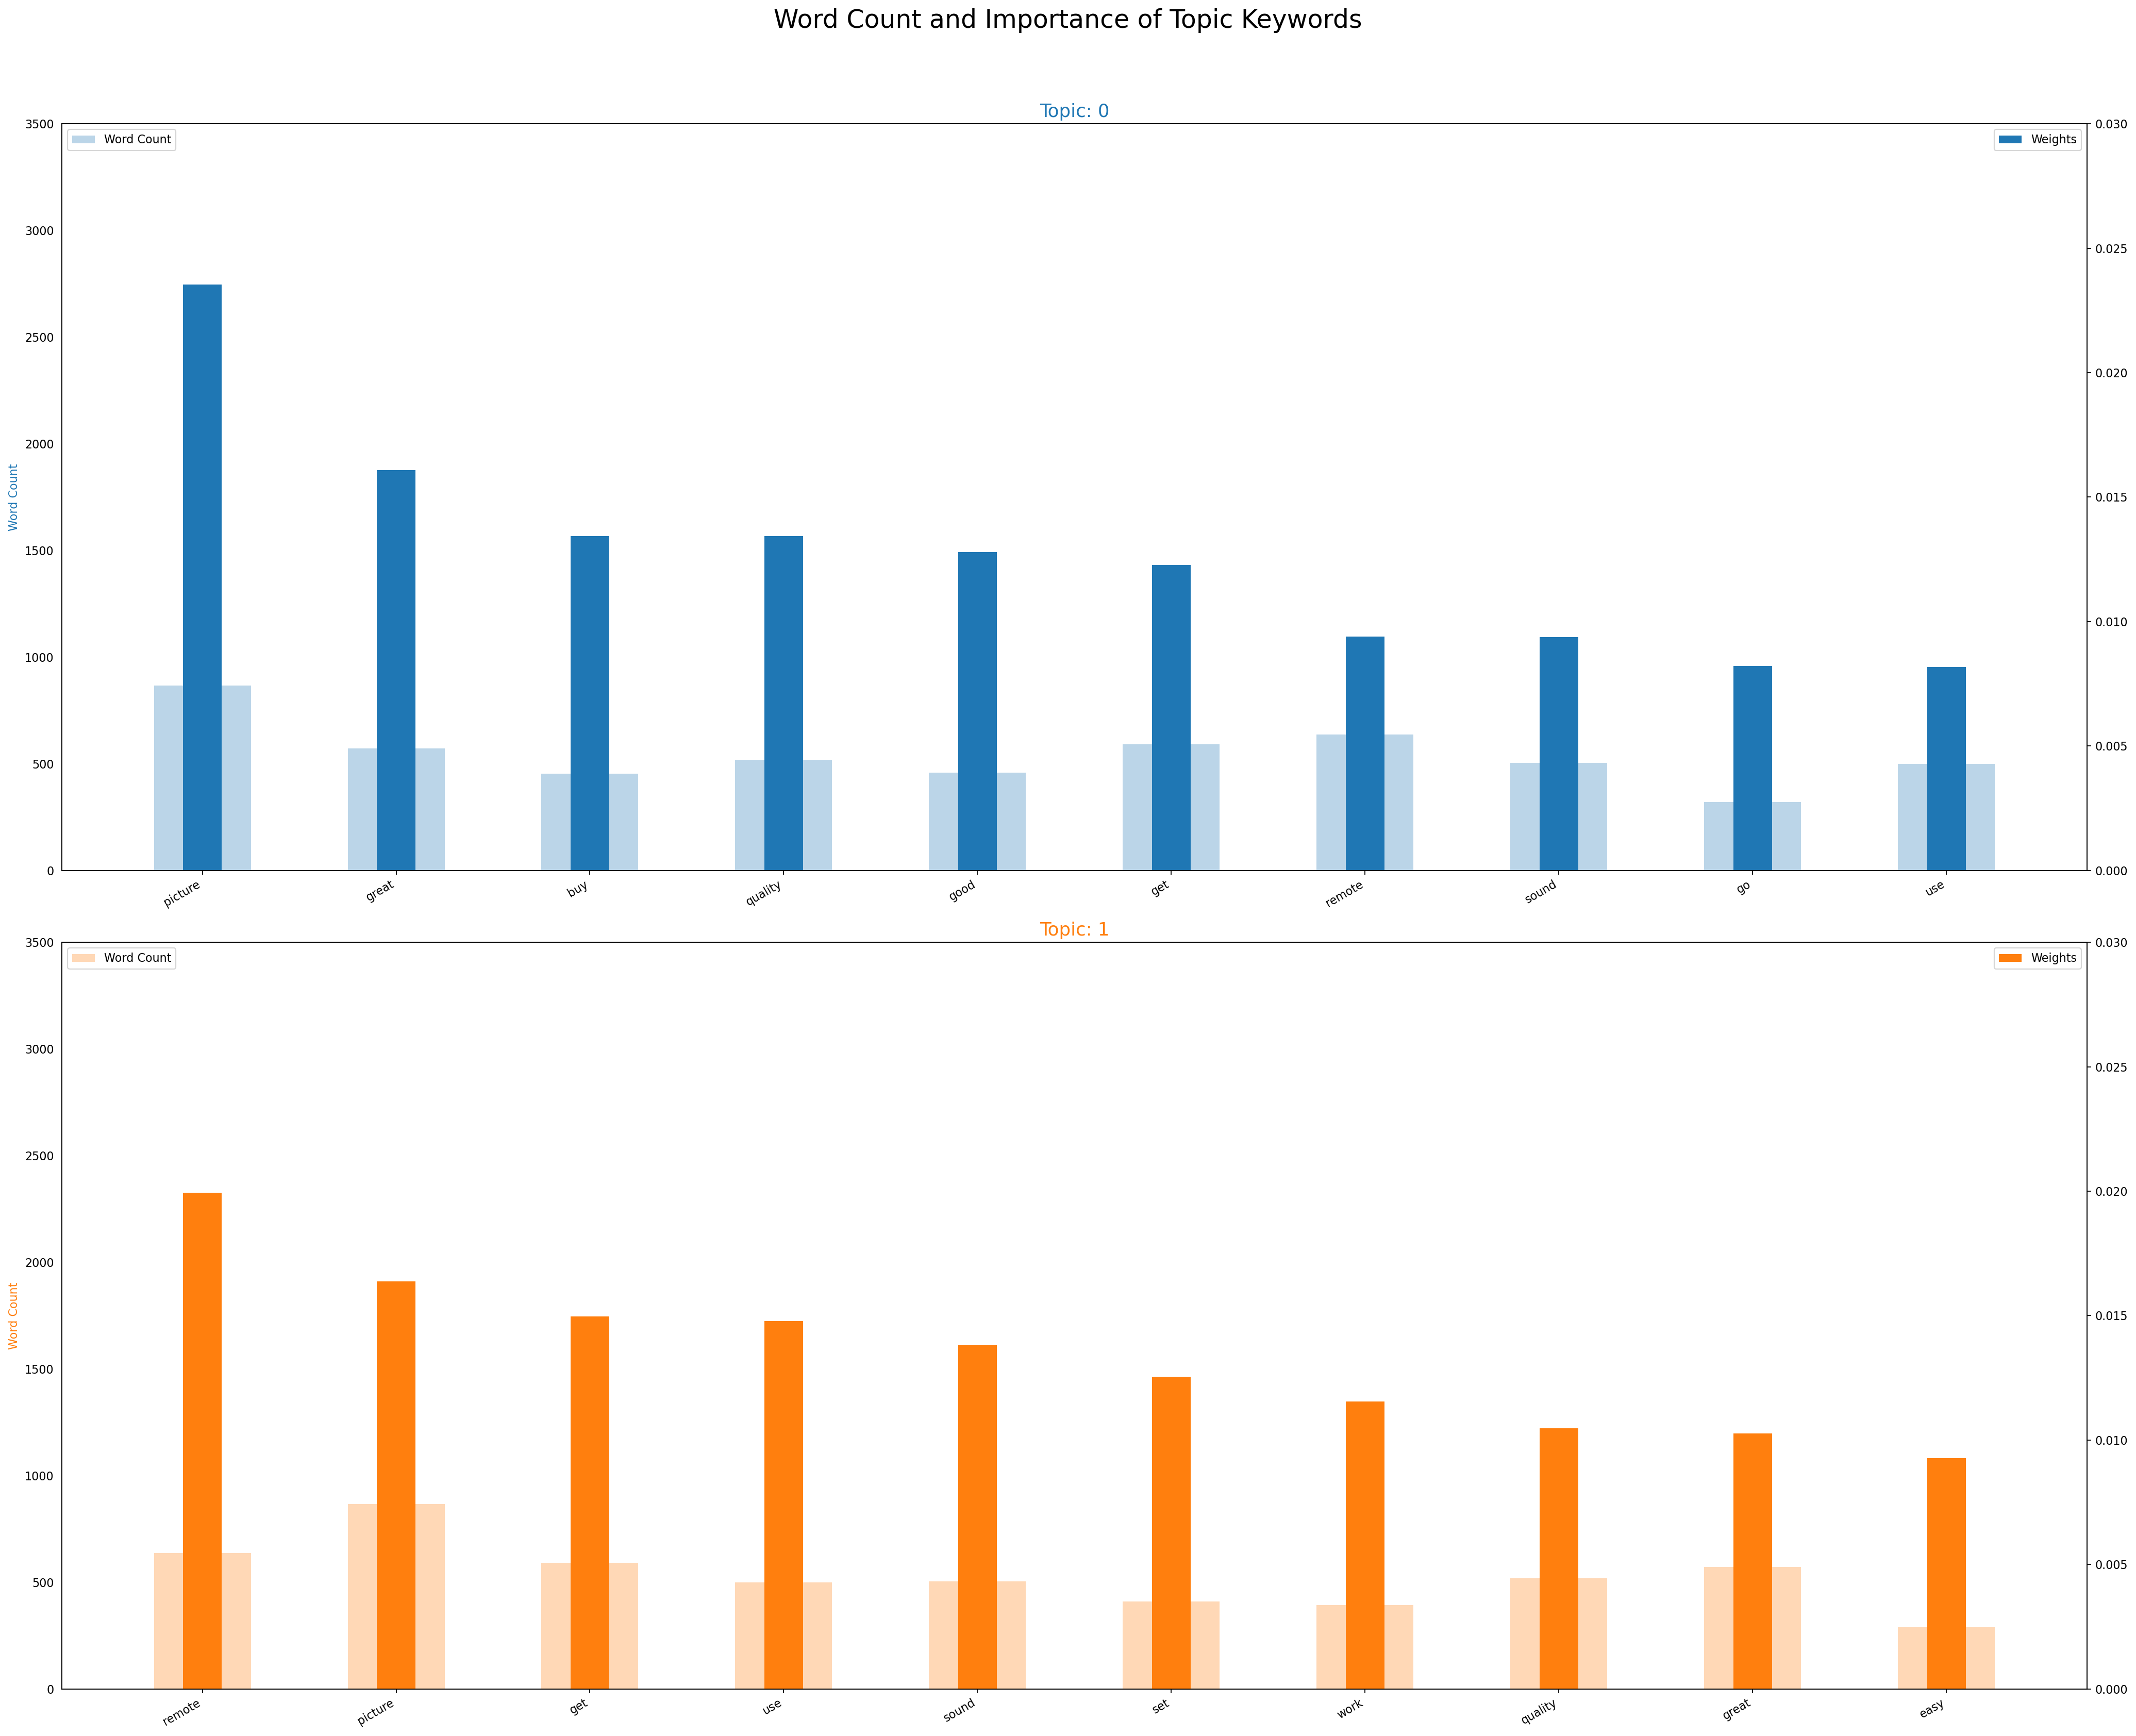

In [62]:
from collections import Counter
topics = final_lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_words for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 1, figsize=(26,20), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)

In [26]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(final_lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.026956  0.0       1        1  52.178274
1     -0.026956  0.0       2        1  47.821726, topic_info=        Term        Freq       Total Category  logprob  loglift
165    sound  477.000000  477.000000  Default  30.0000  30.0000
481  speaker  119.000000  119.000000  Default  29.0000  29.0000
533  setting  102.000000  102.000000  Default  28.0000  28.0000
2      great  525.000000  525.000000  Default  27.0000  27.0000
276     time  282.000000  282.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
2      great  163.201758  525.616896   Topic2  -4.8000  -0.4319
5        set  115.926487  292.692697   Topic2  -5.1420  -0.1885
117     look   83.396298  175.923920   Topic2  -5.4714  -0.0088
3      price   86.354631  198.052684   Topic2  -5.4365  -0.0924
139    smart   89.441449  228.488924   Topic2  -5.4014  -0.2002

[200 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
340       1  0.137517    accept
340       2  0.962619    accept
699       1  0.867807  addition
1811      1  0.157073  advanced
1811      2  0.942440  advanced
...     ...       ...       ...
43        2  0.556181      work
356       1  0.211783     worth
356       2  0.789374     worth
151       1  0.580427      year
151       2  0.417690      year

[284 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

## Analysis:

 we can deduce potential aspects that contribute to the perceived value of the TV-like product. Here's how each topic might relate to perceived value:

Topic 1:

Keywords: picture, great, buy, quality, good, get, remote, sound, go, use
Analysis: This topic suggests that customers perceive value in aspects such as picture quality, sound quality, and overall product quality ("great", "good", "quality"). The positive sentiment associated with terms like "great" and "good" indicates satisfaction with these features, contributing to the perceived value of the product.
Topic 2:

Keywords: remote, picture, get, use, sound, set, work, quality, great, easy
Analysis: This topic emphasizes usability and ease of use ("easy", "use", "set"), suggesting that customers value products that are user-friendly and straightforward to operate. The positive sentiment associated with terms like "great" and "easy" further reinforces the perceived value of the product in terms of convenience and ease of use.
From these topics, we can infer that customers perceive value in features such as picture quality, sound quality, overall product quality, ease of use, and convenience. A TV-like product that excels in these aspects is likely to be perceived as having higher value by customers. Additionally, positive sentiment expressed in reviews further enhances the perceived value of the product.

Therefore, a marketing campaign highlighting these features and emphasizing customer satisfaction could further enhance the perceived value of the TV-like product. Promotional efforts could focus on showcasing the product's superior picture and sound quality, user-friendly interface, and overall positive customer experiences to reinforce its perceived value in the market.king a purchase.by users.



User